# 주제 / 구현

- 모델 
  - SBERT(Sentence-Bert)
  - Bert의 문장 임베딩 이 기능을 개선한 버전
  - SBERT를 사용하기 위해, tranjsformers 패키지를 설치하고 여기서 제공되는 sentence_tranformers 모듈을 이용하여 구현

- 유사도 검사
  - 문장을 벡터화 시키면 수치화가 되어 있어서, 문장과 문장에 대한 유사도 계산을 할 수 있다
  - 여기서는 코사인 유사도 계산식을 활용
    - 내 질문과 유사한 글을 찾아서 (1에 가까운 코사인 유사도 값) 그것에 연관된 답변을 가져온다
      - 질문지 데이터가 많을수록 오래 걸리는 구조 → 챗봇에서 개선 방안

- 데이터
  - 함수로 구현해서 혹은(라이브러리 가져와서 사용)
  - 챗봇에 사용될 질의 / 응답 데이터
  -<a href='https://github.com/songys/Chatbot_data/'>챗봇 Git Hub</a>
  - 송영숙님 제공

- 산출물
  - flask 기반 챗봇 웹서비스
  - 템플릿 부트스트랩 기반
  - <a href=' https://adminlte.io/themes/v3/'>부트스트랩</a>

- 학습
  - 전이학습의 대체 트렌드로 제시된 이컨텍스트 러닝의 제로샷 러닝 기법을 진행

# 트랜스포머 설치


In [1]:
# !pip3 install transformers
!pip3 install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 120 kB 53.7 MB/s 
     |████████████████████████████████| 6.6 MB 40.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.0 MB/s 
     |████████████████████████████████| 1.3 MB 34.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=6d6a77edfd2951bb9acdefa3940bcab3791fb7bad8755f422635ea35dc41e7c7
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


# 2. 챗봇 구현을 위한 질문 / 답변지(시트)  데이터 획득

- Git에 데이터를 등록하여 CDN 서비스처럼 다운받아 사용가능(일종의 저장소 개념)
- 데이터
  - <a href='https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv'>챗봇 다운로드 사이트</a>
  - 챗봇 트레이닝용 문답 페어 11,876개
  - 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
- 주소형식
  - https://raw.githubusercontent.com/{소유자이름}/{repo}/{branch}/{file_name}

In [2]:
import urllib.request
import pandas as pd

In [3]:
# 원격지에 존재하는 리소소를 로컬 PC 특정 위치에 저장
# 만약 405가 뜨ㅓ면, header 쪽에 더미 user-agent값을 셋팅한 후 요청하면 처리된다
src_path = 'https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv'
target_path = 'chatbot_data.txt'
urllib.request.urlretrieve(src_path, target_path)

('chatbot_data.txt', <http.client.HTTPMessage at 0x7fbacef4c6d0>)

# 3. EDA

In [4]:
# law 데이터를 DataFrame으로 변환
chatbot_df = pd.read_csv('/content/chatbot_data.txt')
chatbot_df.head(2)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0


In [6]:
# 결측 데이터 확인
chatbot_df.info(), chatbot_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


(None, Q        0
 A        0
 label    0
 dtype: int64)

In [7]:
# 정답의 종류
chatbot_df.label.unique()

array([0, 1, 2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


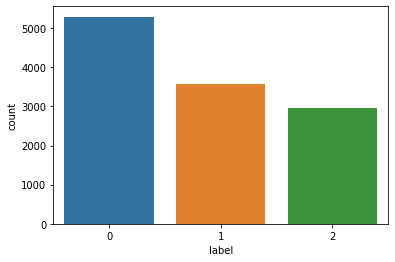

In [11]:
# 레이블별로 분량이 동일한지 확인 → 여기서는 관계 X
import seaborn as sns
sns.countplot(chatbot_df.label)

In [12]:
chatbot_df.shape

(11823, 3)

# 4.Pre-Trained Model Load

- 사전 훈련된 Bert 로드
- Sentence-Bert를 가져와서 활용
- NLI 데이터를 학습한 후, STS 데이터로 파인 튜닝한 모델이다
- 용어
  - <a href='https://hryang06.github.io/nlp/KorNLI-KorSTS/'>용어 간단 참고</a>
- 모델 검색
  - <a href='https://huggingface.co/models?library=sentence-transformers'>트랜스포머 모델 검색</a>
  - 사용 모델
    - <a href=' https://huggingface.co/sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens'>프랜스포머 사용 모델</a>

In [14]:
from sentence_transformers import SentenceTransformer

In [15]:
model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/574 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

- 사용하는 모델 특징
  - 100가지 언어를 지원(다국어 지원)
  - 다국어 Bert Base 모델 기반
  - SNLT 데이터를 학슴
  - STS-B 데이터로 파인튜닝 진행
  - 평균 토큰활용(평균 풀링 활용) → 문장 표현을 위해

- 이 모델의 임베딩 값이 필요한 것

# 5.Q데이터에 임베딩화 진행

- 유사도 계산을 위해서는 텍스트를 벡터화해야 하니까 (최종적으로는 임베딩 값)

In [19]:
# 모델의 인코더를 이용하여 처리
# apply()를 이용하여  Q데이터를 인코딩하여 새로운 컬럼 em에 추가(파생 변수 생성)한다
# dataFrame에서 apply()를 적용하는 것과, Series에서 apply()하는 방식은 조금 다름
chatbot_df['em'] = chatbot_df.Q.apply(lambda x: model.encode(x))

In [20]:
# 임베딩이 완료된 df를 저장하여 백엔드에서 사용
#  파이썬의 모든 형식을 저장할 수 있는 모듈
import pickle

In [28]:
# DataFrame 저장
def df_save(fName, src_df):
  '''
    DataFrame 저장
    fName : 저장할 파일명(경로포함)
    src_df : 저장할 데이터 DataFrame
  '''
  with open(fName, 'wb') as f:
    pickle.dump(src_df, f)

In [31]:
# DataFrame 로드
def df_load(fName):
  '''
    DataFrame 로드
    fName : 저장할 파일명(경로포함)
    return : 파일로부터 읽은 DataFrame
  '''
  with open(fName, 'rb') as f:
    df = pickle.load( f )
  return df

In [33]:
df_save('/content/drive/MyDrive/빅데이터_딥러닝/Day04/chatbot_df.dat', chatbot_df)

In [34]:
# 로드 : 백엔드에 이 파일을 가지고 이 함수를 호출해서 준비한다
tmp = df_load('/content/drive/MyDrive/빅데이터_딥러닝/Day04/chatbot_df.dat')
tmp.head(1)

,Q,A,label,em
0,12시 땡!,하루가 또 가네요.,0,"[0.20179586, -0.03443814, 1.5395721, 0.0106974..."


# 6.유사도 계산 함수 준비

- 코사인 유사도 계산식을 적용한 함수 구현


In [35]:
import numpy as np

In [36]:
def cos_sim(AVec, BVec):
  return np.dot(AVec, BVec) / (np.linalg.norm(AVec) * np.linalg.norm(BVec))

# 7.입력문자와 임베딩한 챗봇 답변 시트간의 탐색 및 유사도 계산 함수

- 유사도 최고 점수를 받은 답변을 찾는 함수

In [44]:
def check_answer_similar( userSentence='' ):
  if not userSentence:
    return '정확하게 입력후 문의하세요'
  # 1. 사용자의 입력 문자를 sbert 모델이 encode()를 호출하여 임베딩 한다 => 백터화
  embeddingSentence   = model.encode( userSentence )
  # 2. 데이터(챗봇 답변 컬럼(A))를 다 돌면서, 사용자가 입력한 문장과 유사도 계산해서 
  #    score 컬럼에 추가
  chatbot_df['score'] = chatbot_df.em.apply( lambda x: cos_sim( x, embeddingSentence) )
  # 3. 이중 최고 스코어를 받은 인덱스(idxmax)를 찾아서 문장을 리턴한다
  #    우연히 최고값이 2개 이상 나오면 가장 먼저 탐색된것이 추출된다
  return chatbot_df.loc[ chatbot_df['score'].idxmax() ]['A']

## TIP df상에서 최고값을 가진 데이터의 위치 찾기

In [38]:
df = pd.DataFrame([1,5,4,2,3])
df

,0
0,1
1,5
2,4
3,2
4,3


In [40]:
df.loc[df.idxmax()]

,0
1,5


# 8.테스트


In [49]:
while True:
  question = input('궁금한점 있으면 물어보세요\t\t')
  if question.lower() == 'q':
    break
  answer   = check_answer_similar( question )
  print( answer )

궁금한점 있으면 물어보세요		메롱
쉽지 않은 결정이었을 거예요
궁금한점 있으면 물어보세요		q
